In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

import warnings 

pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action = 'ignore')

# 1. Data Load

In [3]:
train_original = pd.read_csv('data/train.csv')
test_original = pd.read_csv('data/test.csv')
weather = pd.read_csv('data/weather_hour.csv', encoding = 'cp949')

train = train_original.copy()
test = test_original.copy()

**Time series 데이터의 경우 경향성이나 주기가 나타나므로 각 row의 시간정보를 세분화하여 column화**

In [35]:
def time_data (data) :

    data['Time'] = pd.to_datetime(data['Time'])

    data['day'] = data['Time'].dt.day
    data['month'] = data['Time'].dt.month
    data['year'] = data['Time'].dt.year
    data['hour'] = data['Time'].dt.hour
    data['weekday'] = data['Time'].dt.weekday
    data['weekend'] = 0
    
    for length in range(len(data)) : 
        if data['weekday'][length] > 4 :
            data['weekend'][length] = 1

    return data

In [36]:
train = time_data(train)
test = time_data(test)

# 2. Descriptive Statistics

**전력소모량과 다른 변수들의 특징 파악**  
**feature engineering 코드에서 날씨와 전력 소모량은 크게 상관이 없음을 확인**  
**따라서 날씨 데이터는 본 코드에서 사용 제외**

**전체적인 경향성을 파악하기 위해 Null값이 가장 적은 가구 추출**

In [13]:
def sort_null(data) : 
    null_count = [0] * (data.shape[1] -1)
    for length in range(data.shape[1] - 1) :
        null_count[length] = sum(data.iloc[ : , length + 1].isnull())
        
    column = data.columns[1 : ]
    null_counts = pd.DataFrame({'columns' :column, 
                                'null_count' : null_count})
    
    null_under_7500 = null_counts[null_counts['null_count'] < 7500]
    null_under_7500.sort_values(by = ['null_count'], inplace = True)
    
    return null_under_7500

In [18]:
least_null_house = sort_null(train_original)
least_null_house.head(10)

,columns,null_count
1184,NX1185,0
1174,NX1175,0
1043,NX1044,0
237,NX238,0
282,NX283,0
680,NX681,0
382,NX383,0
330,NX331,25
989,NX990,46
214,NX215,55


**Null 값이 하나도 존재하지 않는 가구는 총 7가구**
**그 중 5개의 가구를 골라 이후 feature engineering에 활용**

*    NX1185
*    NX1175
*    NX283
*    NX681
*    NX383



In [20]:
selected_house = ['NX1185', 'NX1175', 'NX283', 'NX681', 'NX383']

### 전기 사용량 - 시간 상관관계

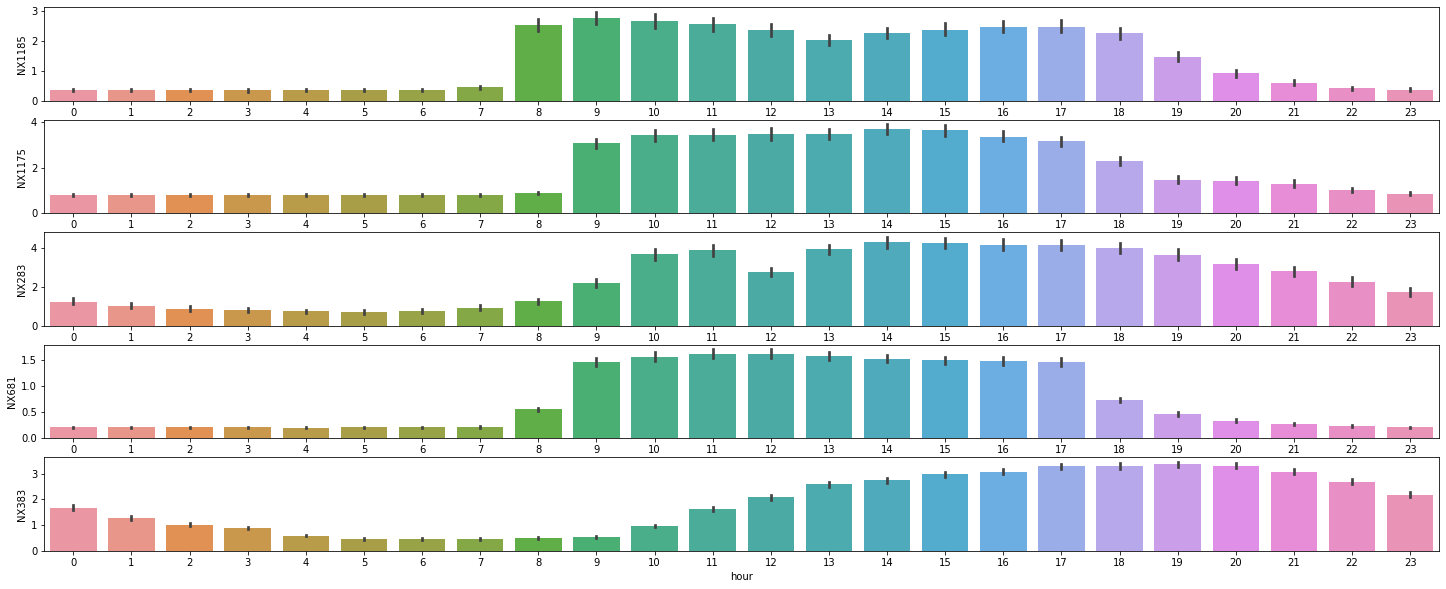

In [22]:
fig, ax = plt.subplots(5, 1, figsize = (25, 10))

for axes in range (5) :
    sns.barplot(x = train['hour'], y = train[selected_house[axes]], ax = ax[axes])
plt.show()

### 전기사용량 - 달 상관관계

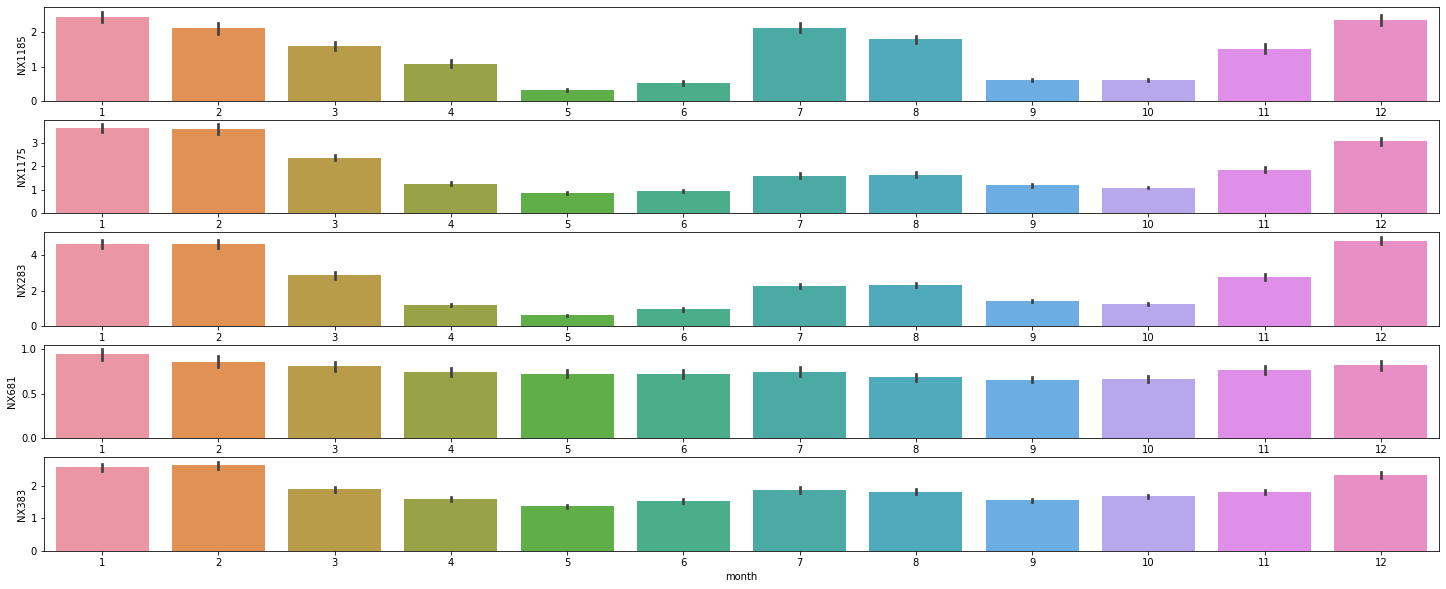

In [24]:
fig, ax = plt.subplots(5, 1, figsize = (25, 10))

for axes in range (5) :
    sns.barplot(x = train['month'], y = train[selected_house[axes]], ax = ax[axes])
plt.show()

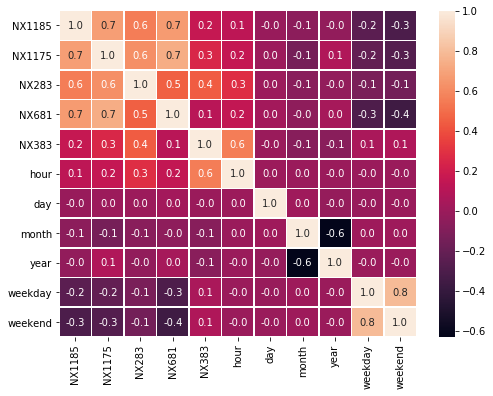

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

selected_train = train[['NX1185', 'NX1175', 'NX283', 'NX681', 'NX383', 'hour', 'day', 'month', 'year', 'weekday', 'weekend']]
sns.heatmap(selected_train.corr(), annot = True, linewidths = 0.5, fmt = '.1f', ax = ax)
plt.show()

In [56]:
train_data = train.drop(['Time'], axis = 1)
train_data

,NX1,NX2,NX3,NX4,NX5,NX6,NX7,NX8,NX9,NX10,NX11,NX12,NX13,NX14,NX15,NX16,NX17,NX18,NX19,NX20,NX21,NX22,NX23,NX24,NX25,NX26,NX27,NX28,NX29,NX30,NX31,NX32,NX33,NX34,NX35,NX36,NX37,NX38,NX39,NX40,NX41,NX42,NX43,NX44,NX45,NX46,NX47,NX48,NX49,NX50,NX51,NX52,NX53,NX54,NX55,NX56,NX57,NX58,NX59,NX60,NX61,NX62,NX63,NX64,NX65,NX66,NX67,NX68,NX69,NX70,NX71,NX72,NX73,NX74,NX75,NX76,NX77,NX78,NX79,NX80,NX81,NX82,NX83,NX84,NX85,NX86,NX87,NX88,NX89,NX90,NX91,NX92,NX93,NX94,NX95,NX96,NX97,NX98,NX99,NX100,NX101,NX102,NX103,NX104,NX105,NX106,NX107,NX108,NX109,NX110,NX111,NX112,NX113,NX114,NX115,NX116,NX117,NX118,NX119,NX120,NX121,NX122,NX123,NX124,NX125,NX126,NX127,NX128,NX129,NX130,NX131,NX132,NX133,NX134,NX135,NX136,NX137,NX138,NX139,NX140,NX141,NX142,NX143,NX144,NX145,NX146,NX147,NX148,NX149,NX150,NX151,NX152,NX153,NX154,NX155,NX156,NX157,NX158,NX159,NX160,NX161,NX162,NX163,NX164,NX165,NX166,NX167,NX168,NX169,NX170,NX171,NX172,NX173,NX174,NX175,NX176,NX177,NX178,NX179,NX180,NX181,NX182,NX183,NX184,NX185,NX186,NX187,NX188,NX189,NX190,NX191,NX192,NX193,NX194,NX195,NX196,NX197,NX198,NX199,NX200,NX201,NX202,NX203,NX204,NX205,NX206,NX207,NX208,NX209,NX210,NX211,NX212,NX213,NX214,NX215,NX216,NX217,NX218,NX219,NX220,NX221,NX222,NX223,NX224,NX225,NX226,NX227,NX228,NX229,NX230,NX231,NX232,NX233,NX234,NX235,NX236,NX237,NX238,NX239,NX240,NX241,NX242,NX243,NX244,NX245,NX246,NX247,NX248,NX249,NX250,...,NX1057,NX1058,NX1059,NX1060,NX1061,NX1062,NX1063,NX1064,NX1065,NX1066,NX1067,NX1068,NX1069,NX1070,NX1071,NX1072,NX1073,NX1074,NX1075,NX1076,NX1077,NX1078,NX1079,NX1080,NX1081,NX1082,NX1083,NX1084,NX1085,NX1086,NX1087,NX1088,NX1089,NX1090,NX1091,NX1092,NX1093,NX1094,NX1095,NX1096,NX1097,NX1098,NX1099,NX1100,NX1101,NX1102,NX1103,NX1104,NX1105,NX1106,NX1107,NX1108,NX1109,NX1110,NX1111,NX1112,NX1113,NX1114,NX1115,NX1116,NX1117,NX1118,NX1119,NX1120,NX1121,NX1122,NX1123,NX1124,NX1125,NX1126,NX1127,NX1128,NX1129,NX1130,NX1131,NX1132,NX1133,NX1134,NX1135,NX1136,NX1137,NX1138,NX1139,NX1140,NX1141,NX1142,NX1143,NX1144,NX1145,NX1146,NX1147,NX1148,NX1149,NX1150,NX1151,NX1152,NX1153,NX1154,NX1155,NX1156,NX1157,NX1158,NX1159,NX1160,NX1161,NX1162,NX1163,NX1164,NX1165,NX1166,NX1167,NX1168,NX1169,NX1170,NX1171,NX1172,NX1173,NX1174,NX1175,NX1176,NX1177,NX1178,NX1179,NX1180,NX1181,NX1182,NX1183,NX1184,NX1185,NX1186,NX1187,NX1188,NX1189,NX1190,NX1191,NX1192,NX1193,NX1194,NX1195,NX1196,NX1197,NX1198,NX1199,NX1200,NX1201,NX1202,NX1203,NX1204,NX1205,NX1206,NX1207,NX1208,NX1209,NX1210,NX1211,NX1212,NX1213,NX1214,NX1215,NX1216,NX1217,NX1218,NX1219,NX1220,NX1221,NX1222,NX1223,NX1224,NX1225,NX1226,NX1227,NX1228,NX1229,NX1230,NX1231,NX1232,NX1233,NX1234,NX1235,NX1236,NX1237,NX1238,NX1239,NX1240,NX1241,NX1242,NX1243,NX1244,NX1245,NX1246,NX1247,NX1248,NX1249,NX1250,NX1251,NX1252,NX1253,NX1254,NX1255,NX1256,NX1257,NX1258,NX1259,NX1260,NX1261,NX1262,NX1263,NX1264,NX1265,NX1266,NX1267,NX1268,NX1269,NX1270,NX1271,NX1272,NX1273,NX1274,NX1275,NX1276,NX1277,NX1278,NX1279,NX1280,NX1281,NX1282,NX1283,NX1284,NX1285,NX1286,NX1287,NX1288,NX1289,NX1290,NX1291,NX1292,NX1293,NX1294,NX1295,NX1296,NX1297,NX1298,NX1299,NX1300,day,month,year,hour,weekday,weekend
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1

**hour과 weekend가 상대적으로 높은 상관관계를 유지하고 있음**

# 3. Feature selection & model 구축